Jupyter workbook for TSM4 masters project

In [1]:
import os

def get_wav_files_and_labels(base_dir):
    data = []
    # base_dir should be the path containing 'insular' and 'pelagic' folders
    for label in ['Insular', 'Pelagic']:
        label_path = os.path.join(base_dir, label)
        # Walk recursively through label folder
        for root, dirs, files in os.walk(label_path):
            # Only process files inside folders named exactly "Raven wave file clips"
            if os.path.basename(root) == "Raven wave file clips":
                for f in files:
                    if f.lower().endswith('.wav'):
                        full_path = os.path.join(root, f)
                        data.append((full_path, label))
    return data

# print number of wav files found
base_dir = '../data'  
wav_label_pairs = get_wav_files_and_labels(base_dir)
print(f"Found {len(wav_label_pairs)} wav files.")


Found 2179 wav files.


In [2]:
wav_label_pairs

[('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_205743_sel_29.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_205743_sel_15.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_205743_sel_01.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_205443_sel_09.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_210443_sel_02.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204443_sel_13.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204443_sel_07.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204643_sel_20.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204643_sel_08.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_338/Raven wave file clips/20171008_204643_sel_09.wav',
  'Insular'),
 ('../data/Insular/Sette_AC_33

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm  # optional for progress bar
# resize all spectrograms to a fixed shape for ML
from skimage.transform import resize

In [4]:
def wav_to_spectrogram_scipy(wav_path, n_fft=8192):
    sample_rate, samples = wavfile.read(wav_path)
    frequencies, times, Sxx = signal.spectrogram(samples, sample_rate, nperseg=n_fft)
    # Sxx is power spectral density, take log to get dB scale
    Sxx_log = np.log(Sxx + 1e-10)  # add small number to avoid log(0)
    # Normalize to 0-1 range
    Sxx_norm = (Sxx_log - Sxx_log.min()) / (Sxx_log.max() - Sxx_log.min())
    return Sxx_norm


spectrograms = []
labels = []

for wav_path, label in tqdm(wav_label_pairs):
    spect = wav_to_spectrogram_scipy(wav_path, n_fft=8192)
    spectrograms.append(spect)
    labels.append(label)



target_shape = (128, 128)
spectrograms_resized = []
valid_labels = []

for i, (s, label) in enumerate(zip(spectrograms, labels)):
    try:
        resized = resize(s, target_shape, mode='constant', anti_aliasing=True)

        # Fix extra singleton dimension if it appears
        if resized.ndim == 3 and resized.shape[-1] == 1:
            resized = np.squeeze(resized, axis=-1)

        # Final shape check
        if resized.shape != target_shape:
            print(f"Warning: Resized shape mismatch at index {i}, got {resized.shape}")
            continue

        spectrograms_resized.append(resized)
        valid_labels.append(label)  # keep label only if resize succeeded

    except Exception as e:
        print(f"Error resizing spectrogram at index {i}: {e}")


        
# Encode labels to integers
label_to_idx = {'Insular': 0, 'Pelagic': 1}
y = np.array([label_to_idx[l] for l in valid_labels])



  5%|▍         | 104/2179 [00:07<01:41, 20.49it/s]/var/folders/bt/njml01qd5wzbf3cq1pr211xw0000gp/T/ipykernel_33343/2898545320.py:3: UserWarning: nperseg = 8192 is greater than input length  = 5, using nperseg = 5
  frequencies, times, Sxx = signal.spectrogram(samples, sample_rate, nperseg=n_fft)
 31%|███       | 669/2179 [00:45<01:39, 15.13it/s]/var/folders/bt/njml01qd5wzbf3cq1pr211xw0000gp/T/ipykernel_33343/2898545320.py:3: UserWarning: nperseg = 8192 is greater than input length  = 3, using nperseg = 3
  frequencies, times, Sxx = signal.spectrogram(samples, sample_rate, nperseg=n_fft)
 42%|████▏     | 913/2179 [01:05<01:50, 11.49it/s]/var/folders/bt/njml01qd5wzbf3cq1pr211xw0000gp/T/ipykernel_33343/2898545320.py:3: UserWarning: nperseg = 8192 is greater than input length  = 6, using nperseg = 6
  frequencies, times, Sxx = signal.spectrogram(samples, sample_rate, nperseg=n_fft)
 55%|█████▍    | 1194/2179 [01:50<03:39,  4.48it/s]/var/folders/bt/njml01qd5wzbf3cq1pr211xw0000gp/T/ipykernel

Spectrogram dataset shape: (2179, 128, 128)
Labels shape: (2179,)


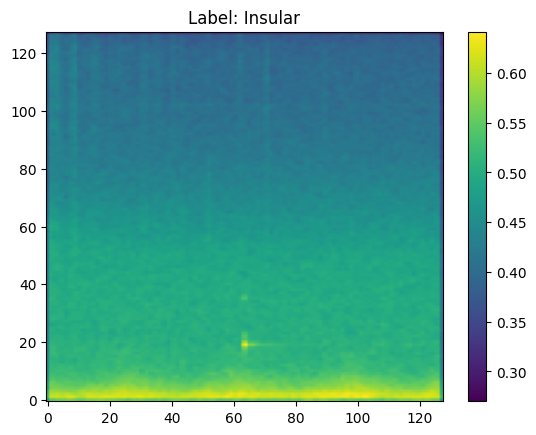

In [5]:
spectrograms_resized = np.array(spectrograms_resized)
print(f"Spectrogram dataset shape: {spectrograms_resized.shape}")
print(f"Labels shape: {y.shape}")

# To visualize one spectrogram
import matplotlib.pyplot as plt
plt.imshow(spectrograms_resized[0], aspect='auto', origin='lower')
plt.title(f"Label: {valid_labels[0]}")
plt.colorbar()
plt.show()

In [6]:
import numpy as np
import pickle

# Save spectrograms and labels
np.save("spectrograms_resized.npy", np.array(spectrograms_resized))
np.save("labels_encoded.npy", y)



In [ ]:


# load
spectrograms_resized = np.load("spectrograms_resized.npy", allow_pickle=True)
y = np.load("labels_encoded.npy")


In [ ]:
plt.imshow(spectrograms_resized[150], aspect='auto', origin='lower')
plt.title(f"Label: {valid_labels[150]}")
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(spectrograms_resized[1000], aspect='auto', origin='lower')
plt.title(f"Label: {valid_labels[1000]}")
plt.colorbar()
plt.show()

Neural net - transfer learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from sklearn.model_selection import train_test_split


In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels, transform=None):
        self.spectrograms = spectrograms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        image = self.spectrograms[idx].astype(np.float32)
        image = np.expand_dims(image, axis=0)  # shape (1, H, W)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(torch.tensor(image))

        return image, label


In [ ]:

X_train, X_val, y_train, y_val = train_test_split(
    spectrograms_resized,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)


In [ ]:
import sys
print(sys.executable)



